In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

C:\Users\16678039\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<center><h3>Loading shperical data from disk</h3></center>

In [2]:
DATA_FILE_2d = './data/data_10000_2dim.csv'
DATA_FILE_3d = './data/data_10000_3dim.csv'
data_2d = pd.read_csv(DATA_FILE_2d, sep=';').drop(['Unnamed: 0'], axis=1)
data_2d = np.array(data_2d)
data_3d = pd.read_csv(DATA_FILE_3d, sep=';').drop(['Unnamed: 0'], axis=1)
data_3d = np.array(data_3d)

<center><h3>Helpers functions</h3></center>

In [3]:
def get_batch(x, batch_index, batch_size, n_batches):
    np.random.seed(n_batches + batch_index) 
    indices = np.random.randint(x.shape[0], size=batch_size) 
    x_batch = x[indices]
    return x_batch

def get_random_noize(dim):
    return np.random.uniform(-1., 1., size=[dim[0], dim[1]])

<center><h3>Simple regular GAN Network</h3></center>

In [4]:
from regular_gan import GAN

<center><h4>Training on 2d data</h4></center>

In [7]:
tf.reset_default_graph()
data_2d_train = np.delete(data_2d[data_2d[:, 2] == 0], 2, 1)
N_DIM = 2
TRAINING_STEPS = 100000
BATCH_SIZE = 100
N_BATCHES = int(np.ceil(data_2d_train.shape[0] / BATCH_SIZE))

gan = GAN(dimension=N_DIM,
          learning_rate=0.001,
          gen_layers=[16, 16], gen_activation=tf.nn.leaky_relu, 
          discr_layers=[16, 16], discr_activation=tf.nn.leaky_relu,
          optimizer=tf.train.RMSPropOptimizer)

init = tf.global_variables_initializer()

losses = []
sess = tf.Session()
sess.run(init)
for i in tqdm(range(TRAINING_STEPS)):
    X_batch = get_batch(data_2d_train, i, BATCH_SIZE, N_BATCHES)
    Z_batch = get_random_noize((BATCH_SIZE, N_DIM))
    dloss, gloss = gan.train_step(sess, X_batch, Z_batch)
    if i % 1000 == 0:
        losses.append([dloss, gloss])

100%|████████████████████████████████| 100000/100000 [01:35<00:00, 1041.80it/s]


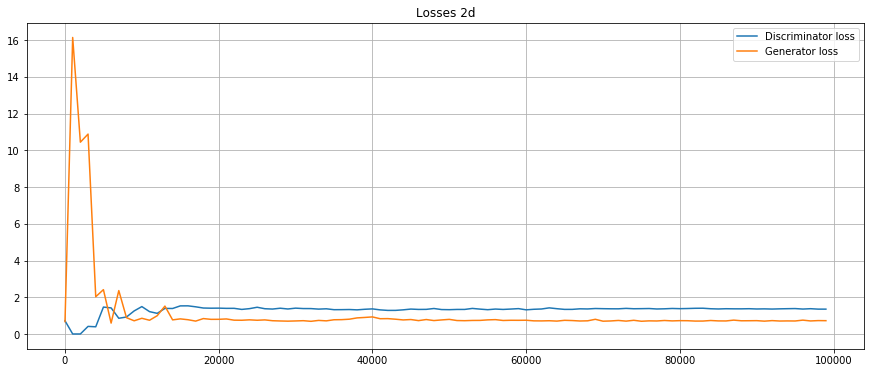

In [8]:
losses = np.array(losses)
time = np.arange(0, TRAINING_STEPS, 1000)

figure = plt.figure(figsize=(15, 6))
plt.plot(time, losses[:, 0])
plt.plot(time, losses[:, 1])
plt.title('Losses 2d')
plt.legend(['Discriminator loss', 'Generator loss'], loc='upper right')
plt.grid()
plt.show()

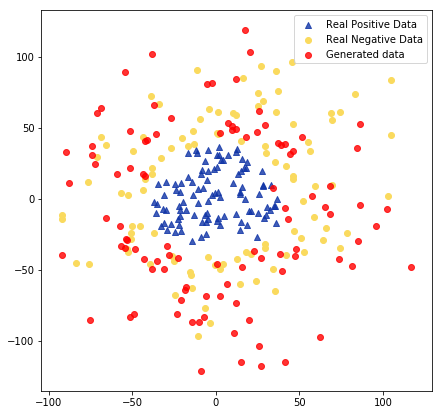

In [9]:
pos_data = data_2d[data_2d[:, 2] == 1][:100]
neg_data = data_2d[data_2d[:, 2] == 0][:100]
Z_batch = get_random_noize((BATCH_SIZE, N_DIM))
gen_samples = sess.run(gan.gen_samples, feed_dict={gan.Z: Z_batch})

figure = plt.figure(figsize=(7, 7))
for c, m, data in [((16/255, 52/255, 166/255, 0.8), '^', pos_data), ((250/255, 218/255, 94/255, 1), 'o', neg_data),
                   ((1, 0, 0, 0.8), 'o', gen_samples)]:
    plt.scatter(data[:, 0], data[:, 1], c=c, marker=m)
plt.legend(['Real Positive Data', 'Real Negative Data', 'Generated data'], loc='upper right')
plt.show()

<center><h4>Training on 3d data</h4></center>

In [9]:
tf.reset_default_graph()
data_3d_train = np.delete(data_3d[data_3d[:, 3] == 1], 3, 1)
N_DIM = 3
TRAINING_STEPS = 100000
BATCH_SIZE = 100
N_BATCHES = int(np.ceil(data_3d_train.shape[0] / BATCH_SIZE))

gan = GAN(dimension=N_DIM,
          learning_rate=0.001,
          gen_layers=[16, 16], gen_activation=tf.nn.leaky_relu, 
          discr_layers=[16, 16], discr_activation=tf.nn.leaky_relu,
          optimizer=tf.train.RMSPropOptimizer)

init = tf.global_variables_initializer()

losses_3d = []
sess = tf.Session()
sess.run(init)
for i in tqdm(range(TRAINING_STEPS)):
    X_batch = get_batch(data_3d_train, i, BATCH_SIZE, N_BATCHES)
    Z_batch = get_random_noize((BATCH_SIZE, N_DIM))
    dloss, gloss = gan.train_step(sess, X_batch, Z_batch)
    if i % 1000 == 0:
        losses_3d.append([dloss, gloss])

100%|█████████████████████████████████| 100000/100000 [01:42<00:00, 976.33it/s]


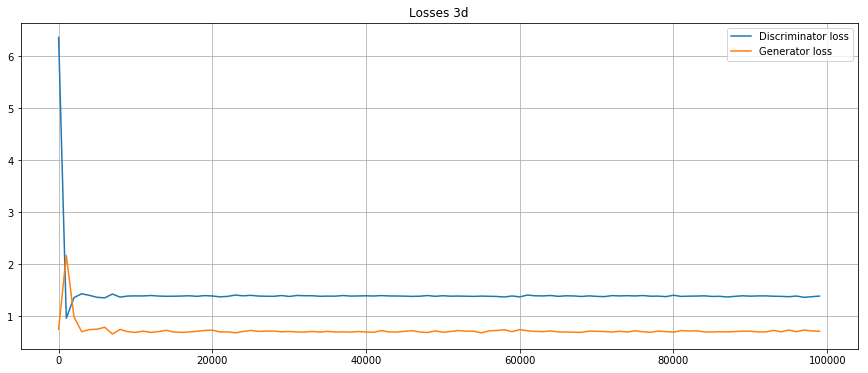

In [10]:
losses_3d = np.array(losses_3d)
time = np.arange(0, TRAINING_STEPS, 1000)

figure = plt.figure(figsize=(15, 6))
plt.plot(time, losses_3d[:, 0])
plt.plot(time, losses_3d[:, 1])
plt.title('Losses 3d')
plt.legend(['Discriminator loss', 'Generator loss'], loc='upper right')
plt.grid()
plt.show()

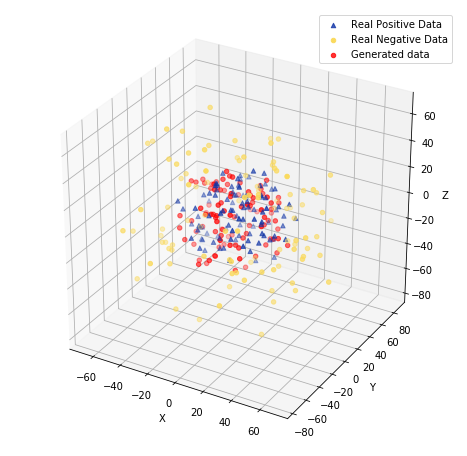

In [14]:
data_3d = np.array(data_3d)
pos_data = data_3d[data_3d[:, 3] == 1][:100]
neg_data = data_3d[data_3d[:, 3] == 0][:100]
Z_batch = get_random_noize((BATCH_SIZE, N_DIM))
gen_samples = sess.run(gan.gen_samples, feed_dict={gan.Z: Z_batch})

figure = plt.figure(figsize=(8, 8))
ax = figure.gca(projection='3d')
for c, m, data in [((16/255, 52/255, 166/255, 0.8), '^', pos_data), ((250/255, 218/255, 94/255, 1), 'o', neg_data),
                   ((1, 0, 0, 0.8), 'o', gen_samples)]:
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=c, marker=m)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend(['Real Positive Data', 'Real Negative Data', 'Generated data'], loc='upper right')
plt.show()

<center><h3>Complementary GAN Network</h3></center>

In [4]:
from complementary_gan import CGAN

In [15]:
tf.reset_default_graph()
min_max_scaler = MinMaxScaler()
data_2d = min_max_scaler.fit_transform(data_2d)
data_2d_train = np.delete(data_2d[data_2d[:, 2] == 0], 2, 1)
N_DIM = 2
TRAINING_STEPS = 10000
BATCH_SIZE = 100
N_BATCHES = int(np.ceil(data_2d_train.shape[0] / BATCH_SIZE))

cgan = CGAN(dimension=N_DIM,
            learning_rate=0.001,
            g_layers=[16, 16], g_activation=tf.nn.leaky_relu, 
            d_layers=[16, 16], d_activation=tf.nn.leaky_relu,
            t_layers=[16, 16], t_activation=tf.nn.leaky_relu,
            optimizer=tf.train.RMSPropOptimizer)

init = tf.global_variables_initializer()

c_losses = []
sess = tf.Session()
sess.run(init)

# print(cgan.real_logits_t.get_shape())
# print(sess.run(tf.shape(cgan.real_logits_t), feed_dict={cgan.T: data_2d_train[:3000]}))
for i in tqdm(range(TRAINING_STEPS)):
    X_batch = get_batch(data_2d_train, i, BATCH_SIZE, N_BATCHES)
    _ = sess.run(cgan.t_training_op, feed_dict={cgan.T: X_batch})

for i in tqdm(range(TRAINING_STEPS)):
    X_batch = get_batch(data_2d_train, i, BATCH_SIZE, N_BATCHES)
    Z_batch = get_random_noize((BATCH_SIZE, N_DIM))
    dloss, gloss = cgan.train_step(sess, X_batch, Z_batch)
    if i % 1000 == 0:
#         print(dloss, gloss)
        c_losses.append([dloss, gloss])

100%|███████████████████████████████████| 10000/10000 [00:14<00:00, 701.79it/s]


[[2.0080738, -8.412972], [1.9839274, -7.846838], [1.9910827, -4.850892], [1.902961, -4.316426], [1.606913, 0.9071121], [1.6406963, -10.590759], [2.4711833, -4.3970222], [2.876658, -7.224538], [0.96177757, -6.8583364], [1.6551061, -6.8366194]]


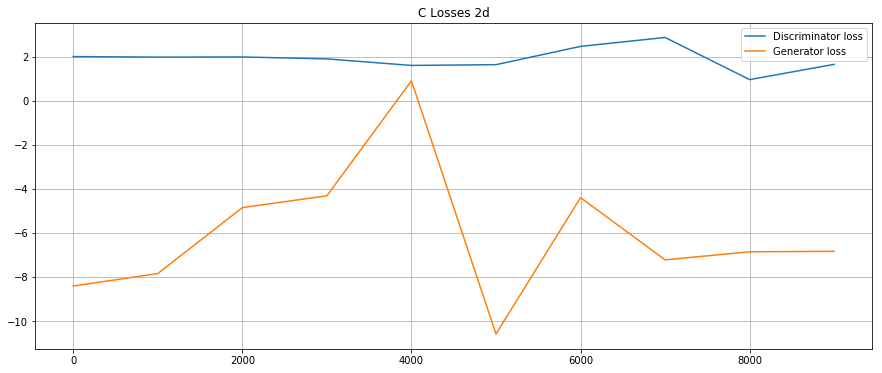

In [16]:
print(c_losses)
c_losses = np.array(c_losses)
time = np.arange(0, TRAINING_STEPS, 1000)

figure = plt.figure(figsize=(15, 6))
plt.plot(time, c_losses[:, 0])
plt.plot(time, c_losses[:, 1])
plt.title('C Losses 2d')
plt.legend(['Discriminator loss', 'Generator loss'], loc='upper right')
plt.grid()
plt.show()

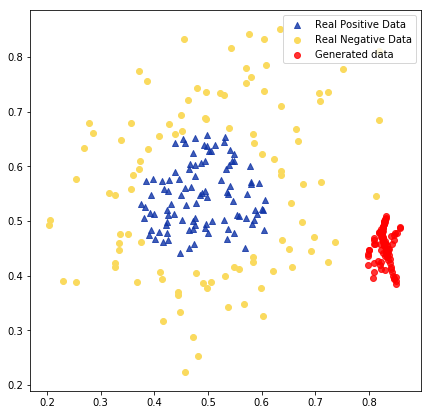

In [19]:
pos_data = data_2d[data_2d[:, 2] == 1][:100]
neg_data = data_2d[data_2d[:, 2] == 0][:100]
Z_batch = get_random_noize((BATCH_SIZE, N_DIM))
gen_samples = sess.run(cgan.g_logit, feed_dict={cgan.Z: Z_batch})

figure = plt.figure(figsize=(7, 7))
for c, m, data in [((16/255, 52/255, 166/255, 0.8), '^', pos_data), ((250/255, 218/255, 94/255, 1), 'o', neg_data),
                   ((1, 0, 0, 0.8), 'o', gen_samples)]:
    plt.scatter(data[:, 0], data[:, 1], c=c, marker=m)
plt.legend(['Real Positive Data', 'Real Negative Data', 'Generated data'], loc='upper right')
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler
tf.reset_default_graph()
dim_input = 2
D_dim = [dim_input, 16, 16, 2]
G_dim = [2, 16, 16, dim_input]
Z_dim = G_dim[0]
mb_size = 100

def sample_shuffle_uspv(X):
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s])

def one_hot(x, depth):
    x_one_hot = np.zeros((len(x), depth), dtype=np.int32)
    x = x.astype(int)
    for i in range(x_one_hot.shape[0]):
        x_one_hot[i, x[i]] = 1
    return x_one_hot

def xavier_init(size): # initialize the weight-matrix W.
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def pull_away_loss(g):

    Nor = tf.norm(g, axis=1)
    Nor_mat = tf.tile(tf.expand_dims(Nor, axis=1),
                      [1, tf.shape(g)[1]])
    X = tf.divide(g, Nor_mat)
    X_X = tf.square(tf.matmul(X, tf.transpose(X)))
    mask = tf.subtract(tf.ones_like(X_X),
                       tf.diag(
                           tf.ones([tf.shape(X_X)[0]]))
                       )
    pt_loss = tf.divide(tf.reduce_sum(tf.multiply(X_X, mask)),
                        tf.multiply(
                            tf.cast(tf.shape(X_X)[0], tf.float32),
                            tf.cast(tf.shape(X_X)[0]-1, tf.float32)))

    return pt_loss

# define placeholders for labeled-data, unlabeled-data, noise-data and target-data.

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])
# X_val = tf.placeholder(tf.float32, shape=[None, dim_input])


# declare weights and biases of discriminator.

D_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
D_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

D_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
D_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

D_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
D_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]



# declare weights and biases of generator.

G_W1 = tf.Variable(xavier_init([G_dim[0], G_dim[1]]))
G_b1 = tf.Variable(tf.zeros(shape=[G_dim[1]]))

G_W2 = tf.Variable(xavier_init([G_dim[1], G_dim[2]]))
G_b2 = tf.Variable(tf.zeros(shape=[G_dim[2]]))

G_W3 = tf.Variable(xavier_init([G_dim[2], G_dim[3]]))
G_b3 = tf.Variable(tf.zeros(shape=[G_dim[3]]))


theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]


# declare weights and biases of pre-train net for density estimation.

T_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
T_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

T_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
T_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

T_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
T_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_T = [T_W1, T_W2, T_W3, T_b1, T_b2, T_b3]


def generator(z):
    G_h1 = tf.nn.leaky_relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.leaky_relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_logit_1 = tf.matmul(G_h2, G_W3) + G_b3
    G_logit = tf.nn.sigmoid(G_logit_1)
    return G_logit, G_logit_1


def discriminator(x):
    D_h1 = tf.nn.leaky_relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2


# pre-train net for density estimation.

def discriminator_tar(x):
    T_h1 = tf.nn.leaky_relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.leaky_relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2


D_prob_real, D_logit_real, D_h2_real = discriminator(X_oc)

G_sample, sam = generator(Z)
D_prob_gen, D_logit_gen, D_h2_gen = discriminator(G_sample)

D_prob_tar, D_logit_tar, D_h2_tar = discriminator_tar(X_tar)
D_prob_tar_gen, D_logit_tar_gen, D_h2_tar_gen = discriminator_tar(G_sample)
# D_prob_val, _, D_h1_val = discriminator(X_val)




# disc. loss
y_real= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
y_gen = tf.placeholder(tf.int32, shape=[None, D_dim[3]])

D_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=D_logit_real,labels=y_real))
D_loss_gen = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=D_logit_gen, labels=y_gen))

ent_real_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_real, tf.log(D_prob_real)), 1
                        )
                    )

ent_gen_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_gen, tf.log(D_prob_gen)), 1
                        )
                    )

D_loss = D_loss_real + D_loss_gen + 1.85 * ent_real_loss


# gene. loss
pt_loss = pull_away_loss(D_h2_tar_gen)

y_tar= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
T_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=D_logit_tar, labels=y_tar))
tar_thrld = tf.divide(tf.reduce_max(D_prob_tar_gen[:,-1]) +
                      tf.reduce_min(D_prob_tar_gen[:,-1]), 2)

# tar_thrld = tf.reduce_mean(D_prob_tar_gen[:,-1])


indicator = tf.sign(
              tf.subtract(D_prob_tar_gen[:,-1],
                          tar_thrld))
condition = tf.greater(tf.zeros_like(indicator), indicator)
mask_tar = tf.where(condition, tf.zeros_like(indicator), indicator)
G_ent_loss = tf.reduce_mean(tf.multiply(tf.log(D_prob_tar_gen[:,-1]), mask_tar))
# G_ent_loss = tf.reduce_mean(tf.log(D_prob_tar_gen[:,-1]))

fm_loss = tf.reduce_mean(
            tf.sqrt(
                tf.reduce_sum(
                    tf.square(D_logit_real - D_logit_gen), 1
                    )
                )
            )

G_loss = pt_loss + G_ent_loss + fm_loss

D_solver = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(G_loss, var_list=theta_G)
T_solver = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(T_loss, var_list=theta_T)


# Load data....


# min_max_scaler = MinMaxScaler()

# if en_ae == 1:
#     x_benign = min_max_scaler.fit_transform(np.load("./data/wiki/ben_hid_emd_4_50_8_200_r0.npy"))
#     x_vandal = min_max_scaler.transform(np.load("./data/wiki/val_hid_emd_4_50_8_200_r0.npy"))
# elif en_ae == 2:
#     x_benign = min_max_scaler.fit_transform(np.load("./data/credit_card/ben_hid_repre_r2.npy"))
#     x_vandal = min_max_scaler.transform(np.load("./data/credit_card/van_hid_repre_r2.npy"))
# else:
#     x_benign = min_max_scaler.fit_transform(np.load("./data/raw_credit_card/ben_raw_r0.npy"))
#     x_vandal = min_max_scaler.transform(np.load("./data/raw_credit_card/van_raw_r0.npy"))


# #x_benign = min_max_scaler.fit_transform(np.load("./hidden_output/ben_hid_emd_4_50_8_200.npy"))
# #x_vandal = min_max_scaler.transform(np.load("./hidden_output/val_hid_emd_4_50_8_200.npy"))


# x_benign = sample_shuffle_uspv(x_benign)
# x_vandal = sample_shuffle_uspv(x_vandal)

# if en_ae == 1:
#     x_benign = x_benign[0:10000]
#     x_vandal = x_vandal[0:10000]
#     x_pre = x_benign[0:7000]
# else:
#     x_pre = x_benign[0:700]
min_max_scaler = MinMaxScaler()
data_2d = min_max_scaler.fit_transform(data_2d)
data_2d_train = np.delete(data_2d[data_2d[:, 2] == 0], 2, 1)   
x_pre = data_2d_train

y_pre = np.zeros(mb_size)
y_pre = one_hot(y_pre, 2)

x_train = x_pre

y_real_mb = one_hot(np.zeros(mb_size), 2)
y_fake_mb = one_hot(np.ones(mb_size), 2)

# if en_ae == 1:
#     x_test = x_benign[-3000:].tolist() + x_vandal[-3000:].tolist()
# else:
#     x_test = x_benign[-490:].tolist() + x_vandal[-490:].tolist()
# x_test = np.array(x_test)


# y_test = np.zeros(len(x_test))
# if en_ae == 1:
#     y_test[3000:] = 1
# else:
#     y_test[490:] = 1


sess = tf.Session()
sess.run(tf.global_variables_initializer())
q = np.divide(len(x_train), mb_size)
# pre-training for target distribution
for n_epoch in range(1000):
    X_mb_oc = sample_shuffle_uspv(x_pre)
    for n_batch in range(int(q)):
        _ = sess.run(T_solver,
             feed_dict={
                X_tar:X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                y_tar:y_pre
                })
#         _, D_loss_curr, ent_real_curr = sess.run([D_solver, D_loss, ent_real_loss],
#                                           feed_dict={
#                                                      X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
#                                                      Z: sample_Z(mb_size, Z_dim),
#                                                      y_real: y_real_mb,
#                                                      y_gen: y_fake_mb
#                                                      })

#         _, G_loss_curr, fm_loss_curr = sess.run([G_solver, G_loss, fm_loss],
        # _, G_loss_curr, fm_loss_, kld_ = sess.run([G_solver, G_loss, fm_loss, pt_loss + G_ent_loss],
#                                            feed_dict={Z: sample_Z(mb_size, Z_dim),
#                                                       X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
#                                                       })
# _ = sess.run(T_solver,
#              feed_dict={
#                 X_tar:x_pre,
#                 y_tar:y_pre
#                 })

q = np.divide(len(x_train), mb_size)

# n_epoch = 1
#
# while n_epoch:

d_ben_pro, d_fake_pro, fm_loss_coll = list(), list(), list()
f1_score  = list()
d_val_pro = list()

# if en_ae == 1:
#     n_round = 50
# else:
#     n_round = 200


def sample_Z(m, n):   # generating the input for G.
    return np.random.uniform(-1., 1., size=[m, n])
c_losses = []
print(len(x_train))
for n_epoch in range(1000):
#     print(n_epoch)
    X_mb_oc = sample_shuffle_uspv(x_train)
#     print(int(q))
    for n_batch in range(int(q)):

        _, D_loss_curr, ent_real_curr = sess.run([D_solver, D_loss, ent_real_loss],
                                          feed_dict={
                                                     X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                     Z: sample_Z(mb_size, Z_dim),
                                                     y_real: y_real_mb,
                                                     y_gen: y_fake_mb
                                                     })

        _, G_loss_curr, fm_loss_curr = sess.run([G_solver, G_loss, fm_loss],
        # _, G_loss_curr, fm_loss_, kld_ = sess.run([G_solver, G_loss, fm_loss, pt_loss + G_ent_loss],
                                           feed_dict={Z: sample_Z(mb_size, Z_dim),
                                                      X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                      })
        if n_batch % 10 == 0:
#             print(D_loss_curr, G_loss_curr)
            c_losses.append([D_loss_curr, G_loss_curr])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

6907


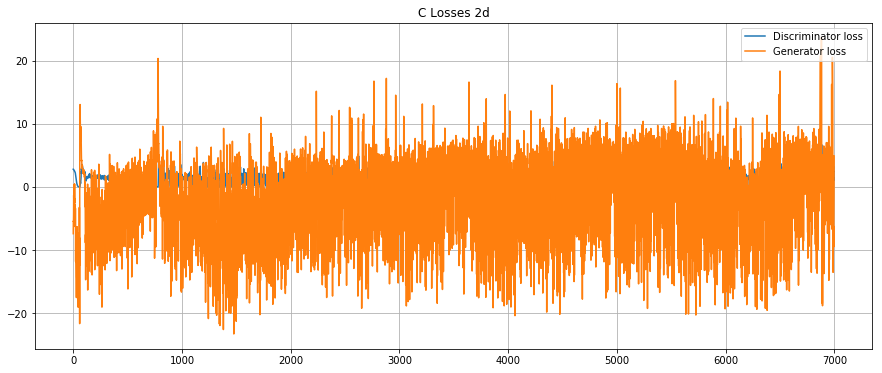

In [5]:
# print(c_losses)
c_losses = np.array(c_losses)
time = np.arange(0, len(c_losses))

figure = plt.figure(figsize=(15, 6))
plt.plot(time, c_losses[:, 0])
plt.plot(time, c_losses[:, 1])
plt.title('C Losses 2d')
plt.legend(['Discriminator loss', 'Generator loss'], loc='upper right')
plt.grid()
plt.show()

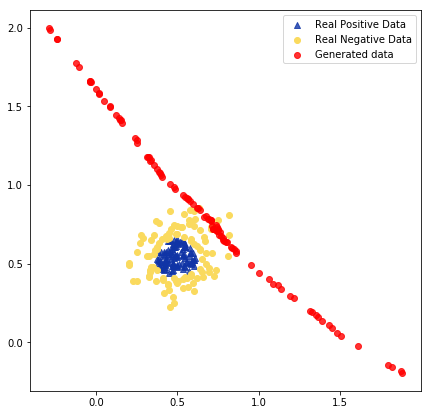

In [6]:
pos_data = data_2d[data_2d[:, 2] == 1][:100]
neg_data = data_2d[data_2d[:, 2] == 0][:100]
Z_batch = get_random_noize((100, 2))
gen_samples = sess.run(sam, feed_dict={Z: sample_Z(mb_size, Z_dim)})
# print(gen_samples)
figure = plt.figure(figsize=(7, 7))
for c, m, data in [((16/255, 52/255, 166/255, 0.8), '^', pos_data), ((250/255, 218/255, 94/255, 1), 'o', neg_data),
                   ((1, 0, 0, 0.8), 'o', gen_samples)]:
    plt.scatter(data[:, 0], data[:, 1], c=c, marker=m)
plt.legend(['Real Positive Data', 'Real Negative Data', 'Generated data'], loc='upper right')
plt.show()